# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

## Project Setup

In [1]:
import pandas as pd
from keplergl import KeplerGl
import geopandas as gpd
import math
from math import *
import sqlite3
import sqlalchemy
from sqlalchemy.orm import sessionmaker
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import sqlalchemy as db
import re
import datetime
import geojsonio
import numpy as np
import geopandas as gpd

In [2]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
# weather csv data file
# 2009_weather to 2015_weather (just pick the first 6 months)
csv__= '/Users/morax/Documents/哥大/IEORE4501/IEOR4501 HW/IEOR4501 Project/'
csv09_file = csv__ + '2009_weather.csv'
csv10_file = csv__ + '2010_weather.csv'
csv11_file = csv__ + '2011_weather.csv'
csv12_file = csv__ + '2012_weather.csv'
csv13_file = csv__ + '2013_weather.csv'
csv14_file = csv__ + '2014_weather.csv'
csv15_file = csv__ + '2015_weather.csv'

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculating distance
In this section in order to calculate the distance between two points in the uber data, we must use the longitude and latitude of the pickup and drop off locations.  Therefore, by using math module in order to calculate the distance between these two coordinates is given in the function calculate_distance().  Two different functions are written below using two different methods of calculating distance using the math module both with varying degrees of accuracy, in some situations the first method is more accurate than the second while in others the reverse is true.  It is important to note that, there are more accurate ways to calculate the distance based upon longitude and latitude that do not use just the math module.  In addtion, in the taxi data sets, the distance is already calculated, however, it is given in miles, so the miles_to_km() function converts the miles to kilometers so that a direct comparison between taxis and ubers can be made.  It should also be noted that the taxi distance is a distance driving on city streets whereas the uber distance is just a birdseye view distance, therefore, the distances in the taxi data set are likely to be slightly longer.  The function, add_distance_column() can be used in order to add the calculated distance to the uber data set.  This function uses the pickup and drop off longitudes and latitudes in order to build the additional column row by row.

In [3]:
def calculate_distance(from_coord, to_coord):
    # Longitude is x, Latitude is y, 
    # Longitude x
    long = (to_coord[0]-from_coord[0])*40000*math.cos((to_coord[1]+from_coord[1])*math.pi/360)/360
    # Latitude y
    lat = (to_coord[1]-from_coord[1])*40000/360
    # so the distance is just the side z followed by x^2+y^2=z^2
    distance = sqrt(long*long+lat*lat)
    return distance

from math import sin, cos, sqrt, atan2, radians
def calculate_distance2(from_coord, to_coord):
    # approximate radius of earth in km
    R = 6373.0

    # Longitude is x, Latitude is y, 
    # math.radians() converts a degree value into radians. 
    lon1 = radians(from_coord[0])
    lat1 = radians(from_coord[1])
    lon2 = radians(to_coord[0])
    lat2 = radians(to_coord[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

# well sometime calculate_distance is better than calculate_distance2

In [4]:
def miles_to_km(distance_miles):
    distance_km = distance_miles /0.62137119
    return distance_km

In [5]:
# Need to fix the variable names called in lambda function
def add_distance_column(dataframe): 
    dataframe['Distance'] = dataframe.apply(lambda x: calculate_distance((x['pickup_longitude'], x["pickup_latitude"]), (x['dropoff_longitude'], x['dropoff_latitude'])),axis=1)


### Processing Taxi Data

In this section, the taxi data set is being processed, the first step in processing the taxi data is first finding the links, then once those links are found they must be read in, and processed by combining each dataset for each month and year into one larger dataset and changing the distance column from miles to kilometers.

-**get_taxi_html() and find_taxi_parquet_urls():** These functions are implementing web scraping in order to find the links for each data set of yellow taxi cabs. The first function, get_taxi_html(), is returning the html content of the web page that has the Taxi data. The second function, find_taxi_parquet_links is from the web page pulling out all of the links, then iterating through those links to see which are datasets for yellow taxi cabs from January 2009 to June 2015.

-**get_and_clean_month_taxi_data(url)** This function reads in the data for each month of each year.  In addition, this funciton also takes a sample of the dataset to match the size of the Uber's dataset.  This means that as the Uber dataset has 1.8 million data points if it is assumed that those data points are evenly distributed across the 78 months, each of the taxi datasets should have approximatly 23076.9 rows in it, therefore, each parquet file is randomly sampled to pick out 23080 rows.

-**zones_within_bbox()** This is a function that uses the taxi zone json file and using the centriod of the zone determines if that zone is within the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047).  If the zone is within the box it is included in the output list which is used later to remove data from some of the taxi files that do not have latitude and longitude included in their data.

-**get_and_clean_taxi_data()** This function concatinates all of the data for each month of each year into one large data set. In addition, it cleans the dataframe data types, removes any points that are outside of the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047) that is essentially the bounds of NYC and normalizes the column names in the files that are from 2009 to 2010 and 2011 to 2015 as they have slightly different names and variables.

In [6]:
def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    # check if the request was succeeded
    if not response.status_code == 200:
        return None
    return html


def find_taxi_parquet_urls():
    soup = bs4.BeautifulSoup(get_taxi_html(), 'html.parser')
    yellow_pattern = r"yellow_tripdata"
    # from Jan. 2009 to June 2015
    year_pattern = r"200\d{1}" # from Jan. 2009 to Dec. 2009
    year_pattern2 = r"201[01234]" # from Jan. 2010 to Dec.2014
    pattern2015 = r"2015-0[123456]" # from Jan. 2015 to June 2015
    link_list = [a['href'] for a in soup.find_all('a')[30:-25]]
    new_links = list()
    for item in link_list:
        # iterate through each year 2009 - 2015
        if (re.search(yellow_pattern, item) != None): 
            if (re.search(year_pattern, item) != None):
                new_links.append(item)
            if (re.search(year_pattern2, item) != None):
                new_links.append(item)
            if (re.search(pattern2015, item) != None):
                new_links.append(item)
    return new_links


In [7]:
def get_and_clean_month_taxi_data(url):
    dataframe = pd.read_parquet(url,engine='pyarrow')
    # Taking a sample of the taxi data:
    return dataframe.sample(n = 23080, random_state=39)


In [8]:
def miles_to_km(distance_miles):
    distance_km = distance_miles /0.62137119
    return distance_km

In [9]:
# This is Code in order to change the taxi zone to a latitude and longitude variable
def get_lat_and_long_from_zone(zone):
    import json
    from shapely.geometry import Point
    df = gpd.read_file('NYCTaxiZones.geojson')
    taxi_zones = gpd.GeoDataFrame(df)
    taxi_zones = taxi_zones.to_crs(4326)

    taxi_zones['lon'] = taxi_zones.centroid.x  
    taxi_zones['lat'] = taxi_zones.centroid.y
    

    for index,row in df.iterrows():
        if zone == row["location_id"]:
            long = row['lon']
            lat = row['lat']
            return lat, long


In [10]:
def zones_within_bbox():
    import json
    from shapely.geometry import Point
    df = gpd.read_file('NYCTaxiZones.geojson')
    taxi_zones = gpd.GeoDataFrame(df)
    taxi_zones = taxi_zones.to_crs(4326)
    taxi_zones['lon'] = taxi_zones.centroid.x  
    taxi_zones['lat'] = taxi_zones.centroid.y
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    taxi_zones = taxi_zones[(taxi_zones["lon"] <= eastlimit) & (taxi_zones["lon"] >= westlimit)] 
    taxi_zones = taxi_zones[(taxi_zones["lat"] <= northlimit) & (taxi_zones["lat"]>= southlimit)]
    zones_in_range =list(taxi_zones["location_id"])
    return zones_in_range

In [11]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    all_csv_urls = find_taxi_parquet_urls()
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        # Making sure that the zone is in the [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
        if 'PULocationID' in dataframe.columns:
            dataframe[dataframe['PULocationID'].isin(zones_within_bbox())]
            dataframe[dataframe['DOLocationID'].isin(zones_within_bbox())]
            # Changing the distance column of each data set from miles to kilometers
            dataframe['trip_distance'] = dataframe.apply(lambda x: x["trip_distance"]/0.62137119, axis = 1)
            # Adding A Pickup Hour Column to the Data
            dataframe['pickup_hour'] = dataframe['tpep_pickup_datetime'].apply(lambda x:x.hour)
            # Removing Unnecessary Columns:
            dataframe = dataframe.drop(["VendorID","payment_type","airport_fee","mta_tax","store_and_fwd_flag","tolls_amount","congestion_surcharge","RatecodeID","extra","improvement_surcharge","fare_amount","passenger_count","total_amount"],axis=1)

            # Normalizing Column Names:
            dataframe.rename(columns ={"trip_distance": "distance", "tpep_pickup_datetime": "pickup_datetime","tpep_dropoff_datetime":"dropoff_datetime"}, inplace = True)
        elif "pickup_longitude" in dataframe.columns:
            # add_distance_column(dataframe)
            dataframe = dataframe[(dataframe["pickup_longitude"] <= eastlimit) & (dataframe["pickup_longitude"] >= westlimit)] 
            dataframe = dataframe [(dataframe ["pickup_latitude"] <= northlimit) & (dataframe["pickup_latitude"]>= southlimit)]
            dataframe  = dataframe[(dataframe["dropoff_longitude"] <= eastlimit) & (dataframe["dropoff_longitude"] >= westlimit)] 
            dataframe = dataframe[(dataframe["dropoff_latitude"] <= northlimit) & (dataframe["dropoff_latitude"]>= southlimit)]

            #Cleaning the date to make Datetime Object (already datetime object?)
            dataframe["dropoff_datetime"]  = dataframe["dropoff_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe["pickup_datetime"]  = dataframe["pickup_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe['pickup_hour'] = dataframe['pickup_datetime'].apply(lambda x:x.hour)

            dataframe = dataframe.drop(["vendor_id","payment_type","mta_tax","store_and_fwd_flag","surcharge","rate_code","tolls_amount","fare_amount","passenger_count","total_amount"], axis = 1)
            
            # Changing the distance column of each data set from miles to kilometers
            dataframe['trip_distance'] = dataframe.apply(lambda x: x["trip_distance"]/0.62137119, axis = 1)
            # Normalizing Column Names
            dataframe.rename(columns ={"trip_distance": "distance"}, inplace = True)

        elif "Trip_Pickup_DateTime" in dataframe.columns:

            dataframe.rename(columns ={"Start_Lon":"pickup_longitude","Start_Lat":"pickup_latitude","End_Lon":"dropoff_longitude","End_Lat":"dropoff_latitude"}, inplace = True)
            dataframe = dataframe[(dataframe["pickup_longitude"] <= eastlimit) & (dataframe["pickup_longitude"] >= westlimit)] 
            dataframe = dataframe [(dataframe ["pickup_latitude"] <= northlimit) & (dataframe["pickup_latitude"]>= southlimit)]

            dataframe  = dataframe[(dataframe["dropoff_longitude"] <= eastlimit) & (dataframe["dropoff_longitude"] >= westlimit)] 
            dataframe = dataframe[(dataframe["dropoff_latitude"] <= northlimit) & (dataframe["dropoff_latitude"]>= southlimit)]

            dataframe = dataframe.drop(["vendor_name","Total_Amt","Tolls_Amt","store_and_forward","mta_tax","surcharge","Fare_Amt","Payment_Type","Rate_Code","Passenger_Count"], axis = 1)
            dataframe["Trip_Pickup_DateTime"]  = dataframe["Trip_Pickup_DateTime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe["Trip_Dropoff_DateTime"]  = dataframe["Trip_Dropoff_DateTime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            dataframe['pickup_hour'] = dataframe["Trip_Pickup_DateTime"].apply(lambda x:x.hour)
            
            dataframe['distance'] = dataframe.apply(lambda x: x["Trip_Distance"]/0.62137119, axis = 1)

            dataframe.rename(columns ={"Tip_Amt":"tip_amount","Trip_Pickup_DateTime":"pickup_datetime","Trip_Dropoff_DateTime":"dropoff_datetime"}, inplace = True)

            dataframe = dataframe.drop(["Trip_Distance"],axis = 1)
        all_taxi_dataframes.append(dataframe)
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    #taxi_data = taxi_data.drop(["Distance"],axis = 1)
    
    return taxi_data

### Processing Uber Data

In this portion of the project, two functions load_and_clean_uber_data() and get_uber_data() are used.  The function load_and_clean_uber_data() reads in the uber data from a csv file and returns a dataframe.  The function get_uber_data() uses the previous function to read in the data, then uses the function add_distance_column previously defined in order to add the distance in kilometers of each trip taken by an uber in the dataset and returns the uber data as a dataframe.  In addition, some additional processing was done ot the data to convert the pickup_datetime into a datetime object and create a column for the day of the week the pickup occured on.  In addition any data that is outside of the bounding box (http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047) was removed.

In [12]:
def load_and_clean_uber_data(csv_file):
    return pd.read_csv(csv_file)

In [29]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    # Making Pickup_datetime a datetime object
    uber_dataframe["pickup_datetime"]  = uber_dataframe["pickup_datetime"].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S %Z'))
    uber_dataframe["day_of_week"]= uber_dataframe['pickup_datetime'].apply(lambda x: x.isoweekday())

    # Removing any data outside of the [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    northlimit  = 40.908524
    southlimit = 40.560445
    eastlimit = -73.717047
    westlimit = -74.242330
    
    uber_dataframe = uber_dataframe[(uber_dataframe["pickup_longitude"] <= eastlimit) & (uber_dataframe["pickup_longitude"] >= westlimit)] 
    uber_dataframe = uber_dataframe [(uber_dataframe ["pickup_latitude"] <= northlimit) & (uber_dataframe["pickup_latitude"]>= southlimit)]

    uber_dataframe  = uber_dataframe[(uber_dataframe["dropoff_longitude"] <= eastlimit) & (uber_dataframe["dropoff_longitude"] >= westlimit)] 
    uber_dataframe = uber_dataframe[(uber_dataframe["dropoff_latitude"] <= northlimit) & (uber_dataframe["dropoff_latitude"]>= southlimit)]

    return uber_dataframe.iloc[:,2:]

### Processing Weather Data

In processing the weather data, two different dataframes (hourly_weather_data, daily_weather_data) were created.  The daily dataframe has data for each day from January 2009 to June 2015 and any duplicate measurment for the days is dropped.  In the hourly data, the data is broken down to each hour of each day from January 2009 to June 2015 and it drops any duplicate measurments that are taken in a given hour. 

In [14]:
def clean_month_weather_data_hourly(csv_file):
    all_data = pd.read_csv(csv_file)

    date = all_data['DATE']
    import datetime
    date = date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
    all_data['hours'] = date.apply(lambda x:x.hour)
    all_data['newDATE'] = 0
    for i in range(len(date)):
        all_data['newDATE'][i] = all_data['DATE'][i][:10]
    hourly_data = all_data
    return hourly_data.drop_duplicates(subset=['hours', 'newDATE'],keep='last')


In [15]:
def clean_month_weather_data_daily(csv_file):
    all_data = pd.read_csv(csv_file)
    date = all_data['DATE']
    import datetime
    date = date.apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
    all_data['days'] = date.apply(lambda x:x.day)
    all_data['newDATE'] = 0
    for i in range(len(date)):
        all_data['newDATE'][i] = all_data['DATE'][i][:7]
    daily_data = all_data
    return daily_data.drop_duplicates(subset=['days', 'newDATE'],keep='last')
    

In [25]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []

    csv09_file = '2009_weather.csv'
    csv10_file = '2010_weather.csv'
    csv11_file =  '2011_weather.csv'
    csv12_file = '2012_weather.csv'
    csv13_file = '2013_weather.csv'
    csv14_file = '2014_weather.csv'
    csv15_file = '2015_weather.csv'
    weather_csv09_14_files = [csv09_file, csv10_file, csv11_file, csv12_file, csv13_file, csv14_file]
    
    for csv_file in weather_csv09_14_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
    hourly_15_dataframe = clean_month_weather_data_hourly(csv15_file).iloc[:4344]
    hourly_dataframes.append(hourly_15_dataframe)
    daily_15_dataframe = clean_month_weather_data_daily(csv15_file).iloc[:181]
    daily_dataframes.append(daily_15_dataframe)

    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes).reset_index(drop=True).iloc[:, [1,2,3,5,11,21,22,23,-2,-1]]
    daily_data = pd.concat(daily_dataframes).reset_index(drop=True).iloc[:, [1,2,3,5,32,38,39,40,43,44,-2,-1]]
    
    return hourly_data, daily_data

### Process All Data

Once all of the functions in order to process the data have been written each of those functions can be executed.  Executing each of these functions, provides four clean data sets, taxi_data, uber_data, hourly_weather_data, and daily_weather_data.

In [30]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [32]:
# clean data a little bit more
taxi_data_clean = taxi_data.set_index([pd.Series(np.arange(len(taxi_data['distance'])))])  


## Part 2: Storing Cleaned Data

Once the data was read and cleaned it is stored in a SQL database. In this portion, four tables (hourly_weather, daily_weather, taxi_trips, and uber_trips) were created to store the different dataframes data.

In [35]:
engine = db.create_engine(DATABASE_URL)

In [36]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    NAME TEXT,
    HourlyPrecipitation STRING,
    HourlyWindDirection STRING,
    HourlyWindGustSpeed STRING,
    HourlyWindSpeed	STRING,
    hours INTEGER,
    newDATE STRING
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    NAME TEXT,
    DailyAverageWindSpeed STRING,
    DailyPeakWindDirection STRING,
    DailyPeakWindSpeed STRING,
    DailyPrecipitation STRING,
    DailySustainedWindDirection STRING,
    DailySustainedWindSpeed STRING,
    days INTEGER,
    newDATE STRING
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,	
    pickup_datetime	TIMESTAMP,
    dropoff_datetime DATE,
    distance FLOAT,
    PULocationID FLOAT,
    DOLocationID FLOAT,
    tip_amount FLOAT,
    pickup_hour FLOAT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    fare_amount	FLOAT,
    pickup_datetime TIMESTAMP,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    Distance FLOAT,
    day_of_week INTEGER
);
"""

In [37]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)


In [38]:
# create the tables with the schema files
with engine.connect() as connection:
    engine.connect().execute(
        HOURLY_WEATHER_SCHEMA
    )
    engine.connect().execute(
        DAILY_WEATHER_SCHEMA
    )
    engine.connect().execute(
        TAXI_TRIPS_SCHEMA
    )
    engine.connect().execute(
        UBER_TRIPS_SCHEMA
    )

pd.read_sql_query - read data from querying a SQL table

pd.read_sql_table - read entire SQL table

df.to_sql - add data from the dataframe to a SQL table

pd.to_numeric - Convert argument to a numeric type

pd.concat - Concatenate pandas objects along a particular axis with optional set logic along the other axes

pd.merge - Merge DataFrame or named Series objects with a database-style join

pd.merge_asof - Perform a merge by key distance. This is similar to a left-join except that we match on the nearest key rather than equal keys. Both DataFrames must be sorted by the key.

### Add Data to Database

Once the data is cleaned and the SQL tables are set up, the data that was read in to the file early can be added to the database, which is done during this step for each of the four tables

In [39]:
def write_dataframes_to_table(table_to_df_dict):
    for item_0, item_1 in table_to_df_dict.items():
        # add data from the dataframe to a SQL table
        item_1.to_sql(item_0, engine, index_label="id", if_exists="append", index=True)

In [40]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data_clean,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [41]:
write_dataframes_to_table(map_table_name_to_dataframe)

In [42]:
!sqlite3 project.db < schema.sql

## Part 3: Understanding the Data

In this section, six queries are done to the SQL tables in order to determine the following information about taxi and uber trips:
* For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* What is the 95% percentile of distance traveled for all hired trips during July 2013?
* What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [47]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as o:
        o.write(query)


### For the same time frame, what day of the week was the most popular to take an uber? 
In this portion, in order to determine the most popular day of the week for uber trips, the number of times a certain day of week appears in the dataset is counted and then ordered by days of that count. 


From the output, we find Friday is the most popular day to take an uber among the week.


In [48]:
Uber_day_most_pop = """
    SELECT day_of_week FROM uber_trips GROUP BY day_of_week ORDER BY COUNT(day_of_week) DESC
"""

In [49]:
engine.execute(Uber_day_most_pop).fetchall()
# Friday is the most popular day

[(5,), (6,), (4,), (3,), (2,), (7,), (1,)]

In [50]:
write_query_to_file(Uber_day_most_pop, "Uber_most_pop_day.sql")

### Most Popular Hour Taxis Query

In this section, in order to determine the post popular hour for a taxi pickup to occur at, the number of times a pickup hour occurs in the database is counted, then it is ordered by that count.

We find out the most popular hour of pickup is 7p.m..

In [51]:
taxi_hour_most_pop = """
    SELECT pickup_hour, COUNT(pickup_hour) FROM taxi_trips GROUP BY pickup_hour ORDER BY COUNT(pickup_hour) DESC
    """

In [52]:
engine.execute(taxi_hour_most_pop).fetchall()
# The most popular hour for a tzxi pickup to occur is at 19(same as 7p.m.).

[(19.0, 111676),
 (18.0, 107562),
 (20.0, 105567),
 (21.0, 102491),
 (22.0, 99690),
 (14.0, 90793),
 (23.0, 88970),
 (17.0, 88767),
 (12.0, 87899),
 (13.0, 87399),
 (15.0, 85954),
 (9.0, 83415),
 (11.0, 82853),
 (8.0, 81141),
 (10.0, 79896),
 (16.0, 74176),
 (0.0, 71349),
 (7.0, 64168),
 (1.0, 52371),
 (2.0, 39011),
 (6.0, 36858),
 (3.0, 28697),
 (4.0, 21088),
 (5.0, 17558)]

In [53]:
write_query_to_file(taxi_hour_most_pop, "Taxi_hour_most_pop.sql")

### What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

Those are what we found: (top 10 days, number of hired rides, average distance)
* ('2009-01-24', 954, 4.144043945487254), 
* ('2009-02-06', 950, 3.954700317060508),
* ('2009-02-13', 942, 4.41544541717232),
* ('2009-02-20', 937, 4.269175717911793),
* ('2009-12-18', 932, 4.236252742463521),
* ('2009-11-07', 928, 4.112689012049695),
* ('2009-02-14', 922, 4.161969567089876),
* ('2009-06-05', 910, 4.084019903935855),
* ('2009-02-05', 909, 3.9356516513985897),
* ('2009-09-10', 909, 4.2768361215379675)

In [54]:
top_10_days_2009 = """
SELECT DATE(pickup_datetime), COUNT(DATE(pickup_datetime)), AVG(distance)
FROM taxi_trips 
WHERE pickup_datetime LIKE '2009-%-%'
GROUP BY DATE(pickup_datetime)
UNION
SELECT DATE(pickup_datetime), COUNT(DATE(pickup_datetime)), AVG(Distance)
FROM uber_trips 
WHERE pickup_datetime LIKE '2009-%-%'
GROUP BY DATE(pickup_datetime) 
ORDER BY COUNT(DATE(pickup_datetime)) DESC
LIMIT 10
"""

In [55]:
engine.execute(top_10_days_2009).fetchall()
# TOP 10 days, no. of rides, average distance

[('2009-01-24', 954, 4.144043945487254),
 ('2009-02-06', 950, 3.954700317060508),
 ('2009-02-13', 942, 4.41544541717232),
 ('2009-02-20', 937, 4.269175717911793),
 ('2009-12-18', 932, 4.236252742463521),
 ('2009-11-07', 928, 4.112689012049695),
 ('2009-02-14', 922, 4.161969567089876),
 ('2009-06-05', 910, 4.084019903935855),
 ('2009-02-05', 909, 3.9356516513985897),
 ('2009-09-10', 909, 4.2768361215379675)]

In [56]:
write_query_to_file(top_10_days_2009, "top_10_days_2009.sql")

### Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?


Those are what we found: (top 10 days, avg. wind speed, number of hired trips)
* ('2014-03-13', 14.1, 934),
* ('2014-01-07', 13.1, 869),
* ('2014-02-13', 12.6, 652),
* ('2014-01-02', 12.2, 652),
* ('2014-03-26', 11.9, 811),
* ('2014-12-07', 11.8, 904),
* ('2014-12-08', 11.5, 805),
* ('2014-11-02', 10.8, 847),
* ('2014-03-29', 10.8, 994),
* ('2014-02-14', 10.4, 854)

In [63]:
# weather data below
windiest_days= """
WITH taxi_trip(select_day, count) AS (
    SELECT DATE(pickup_datetime) AS select_day, COUNT(DATE(pickup_datetime)) AS count
    FROM taxi_trips
    WHERE select_day LIKE '2014-%-%'
    GROUP BY select_day
    ORDER BY count DESC
    ),
    uber_trip(select_day, count) AS (
    SELECT DATE(pickup_datetime) AS select_day, COUNT(DATE(pickup_datetime)) AS count
    FROM uber_trips
    WHERE select_day LIKE '2014-%-%'
    GROUP BY select_day
    ORDER BY count DESC
    ),
    daily_w(select_day, daw) AS (
    SELECT DATE(DATE) AS select_day, DailyAverageWindSpeed AS daw
    FROM daily_weather
    WHERE select_day LIKE '2014-%-%'
    GROUP BY select_day
    ORDER BY daw DESC
    LIMIT 10
    )
    SELECT daily_w.select_day, daily_w.daw, taxi_trip.count+uber_trip.count
    FROM daily_w
    LEFT JOIN taxi_trip ON daily_w.select_day = taxi_trip.select_day
    LEFT JOIN uber_trip ON daily_w.select_day = uber_trip.select_day;
"""


In [64]:
engine.execute(windiest_days).fetchall()
# (top 10 days, avg_wind_speed, hired trips)

[('2014-03-13', 14.1, 934),
 ('2014-01-07', 13.1, 869),
 ('2014-02-13', 12.6, 652),
 ('2014-01-02', 12.2, 652),
 ('2014-03-26', 11.9, 811),
 ('2014-12-07', 11.8, 904),
 ('2014-12-08', 11.5, 805),
 ('2014-11-02', 10.8, 847),
 ('2014-03-29', 10.8, 994),
 ('2014-02-14', 10.4, 854)]

In [65]:
write_query_to_file(windiest_days, "windiest_days.sql")

### What is the 95% percentile of distance traveled for all hired trips during July 2013?

We found 15.771571256787752 is the 95% percentile of distance traveled for all hired trips during July 2013.


In [66]:
distance_95th_2013 ="""
SELECT distance AS distance, DATE(pickup_datetime) AS date
FROM taxi_trips
WHERE date LIKE '2013-07-%'
UNION ALL
SELECT Distance AS distance, DATE(pickup_datetime) AS date
FROM uber_trips
WHERE date LIKE '2013-07-%'
ORDER BY distance
LIMIT 1
OFFSET (
    WITH t(count) AS
    (SELECT COUNT(distance) AS count
    FROM taxi_trips
    WHERE DATE(pickup_datetime) LIKE '2013-07-%'),
    u(count) AS
    (SELECT COUNT(Distance) AS count
    FROM uber_trips
    WHERE DATE(pickup_datetime) LIKE '2013-07-%')
    SELECT t.count+u.count
    FROM t
    JOIN u)*95/100-1;
"""

In [67]:
engine.execute(distance_95th_2013).fetchall()
# 95% percentile, the corresponding date

[(15.771571256787752, '2013-07-29')]

In [68]:
write_query_to_file(distance_95th_2013, "95th_distance_2013.sql")

### During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

Those are what we found: (hour, COUNT(trips), precipitation, Hourlywindspeed)
* (0, 415, 0.0013333333333333333, 6.0),
* (1, 350, 0.0006666666666666666, 4.9375),
* (2, 250, 0.002142857142857143, 5.25),
* (3, 177, 0.0026666666666666666, 6.8),
* (4, 142, 0.0, 6.2),
* (5, 128, 0.0006666666666666666, 5.0625),
* (6, 245, 0.002, 6.5625),
* (7, 421, 0.0013333333333333333, 5.928571428571429),
* (8, 497, 0.0033333333333333335, 6.8),
* (9, 499, 0.006, 6.625),
* (10, 502, 0.002, 5.666666666666667),
* (11, 607, 0.0, 6.533333333333333),
* (12, 601, 0.00375, 7.375),
* (13, 545, 0.002857142857142857, 7.615384615384615),
* (14, 580, 0.0013333333333333333, 8.384615384615385),
* (15, 522, 0.007333333333333333, 7.769230769230769),
* (16, 500, 0.006666666666666666, 7.6),
* (17, 586, 0.004666666666666667, 7.0),
* (18, 661, 0.0013333333333333333, 7.133333333333334),
* (19, 706, 0.000625, 6.625),
* (20, 705, 0.00125, 6.666666666666667),
* (21, 656, 0.0, 6.9375),
* (22, 641, 0.001875, 5.6875),
* (23, 556, None, None) 




In [69]:
sandy = """ 
WITH taxi(hour, count) AS (
    SELECT CAST(pickup_hour AS int) AS hour, COUNT(pickup_hour) AS count
    FROM taxi_trips
    WHERE DATE(pickup_datetime) BETWEEN '2012-10-22' AND '2012-11-06'
    GROUP BY hour),
    uber(hour, count) AS (
    SELECT CAST(strftime('%H', pickup_datetime) AS int) AS hour, COUNT(strftime('%H', pickup_datetime)) AS count
    FROM uber_trips
    WHERE DATE(pickup_datetime) BETWEEN '2012-10-22' AND '2012-11-06'
    GROUP BY hour),
    weather(hour, precip, wspeed) AS (
    SELECT CAST(hours AS int) AS hour, AVG(HourlyPrecipitation) AS precip, AVG(HourlyWindSpeed) AS wspeed
    FROM hourly_weather
    WHERE DATE(DATE) BETWEEN '2012-10-22' AND '2012-11-06'
    GROUP BY hour)
    SELECT weather.hour, taxi.count+uber.count, weather.precip, weather.wspeed
    FROM weather
    LEFT JOIN taxi ON taxi.hour = weather.hour
    LEFT JOIN uber ON uber.hour = weather.hour;
"""

In [70]:
engine.execute(sandy).fetchall()
# hour, COUNT(trips), precipitation, Hourlywindspeed

[(0, 415, 0.0013333333333333333, 6.0),
 (1, 350, 0.0006666666666666666, 4.9375),
 (2, 250, 0.002142857142857143, 5.25),
 (3, 177, 0.0026666666666666666, 6.8),
 (4, 142, 0.0, 6.2),
 (5, 128, 0.0006666666666666666, 5.0625),
 (6, 245, 0.002, 6.5625),
 (7, 421, 0.0013333333333333333, 5.928571428571429),
 (8, 497, 0.0033333333333333335, 6.8),
 (9, 499, 0.006, 6.625),
 (10, 502, 0.002, 5.666666666666667),
 (11, 607, 0.0, 6.533333333333333),
 (12, 601, 0.00375, 7.375),
 (13, 545, 0.002857142857142857, 7.615384615384615),
 (14, 580, 0.0013333333333333333, 8.384615384615385),
 (15, 522, 0.007333333333333333, 7.769230769230769),
 (16, 500, 0.006666666666666666, 7.6),
 (17, 586, 0.004666666666666667, 7.0),
 (18, 661, 0.0013333333333333333, 7.133333333333334),
 (19, 706, 0.000625, 6.625),
 (20, 705, 0.00125, 6.666666666666667),
 (21, 656, 0.0, 6.9375),
 (22, 641, 0.001875, 5.6875),
 (23, 556, None, None)]

In [71]:
write_query_to_file(sandy, "Sandy.sql")

## Part 4: Visualizing the Data


### Visualization: For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? 
The plot below uses all the yellow taxi data to determine the most popular hour of the day for pickups.  Pickups peak around the 19th hour of the day, as the analysis has a zero hour this would be around 8 PM.

In [72]:
def plot_visual_taxi_hour(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = dataframe['pickup_hour']  # use the dataframe to pull out values needed to plot
    counts = dataframe['COUNT(pickup_hour)']
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    # axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # axes.plot(values, counts)
    plt.bar(values, counts)
    plt.ylabel("Number of Taxi Trips")
    plt.xlabel("Pickup Hour")
    # and set up axes labels, etc
    axes.set_title("Most Popular Hour of the Day to take a Yellow Taxi January 2009 to June 2015")
    
    plt.show()

In [74]:
def get_data_for_visual_taxi_hour():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    # Read the sql file
    query = open('Taxi_hour_most_pop.sql', 'r')
    # connection == the connection to your database, in your case prob_db
    data = pd.read_sql_query(query.read(),DATABASE_URL)
    return data

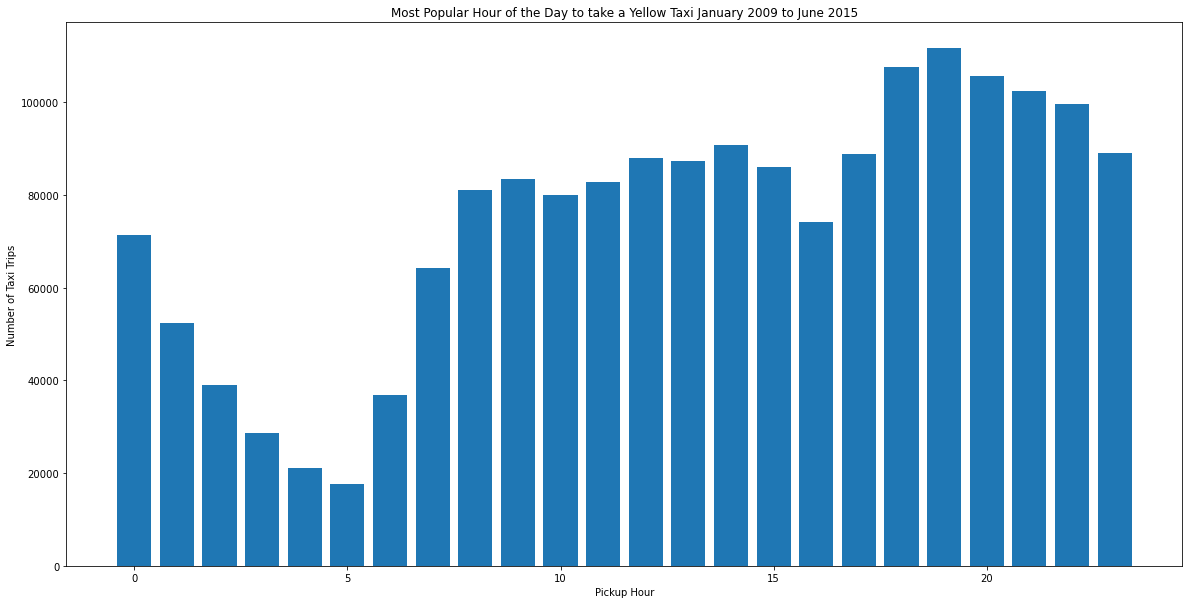

In [75]:
taxi_hour_most_pop = get_data_for_visual_taxi_hour()
plot_visual_taxi_hour(taxi_hour_most_pop)


### Visualization: Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR. Compares what day of the week was most popular for drop offs for each airport.

The coordinates used for each respective airport:
* EWR (Newark): -74.195995,40.664103,-74.148445,40.713045
* JFK: -73.832496,40.618362,-73.744262,40.669421
* LGA (LaGuardia): -73.892010,40.764638,-73.852357,40.787711

In [76]:
def get_airport(lon,lat):
    #MY CODE STARTS HERE
    # long is x lat is y 
    southwestEWR = [-74.195995,40.664103]
    southeastEWR = [-74.148445,40.664103]
    northeastEWR = [-74.148445,40.713045]
    northwestEWR = [-74.195995,40.713045]
    EWR = (('EWR'),[southwestEWR,southeastEWR,northeastEWR,northwestEWR,southwestEWR])
    southwestJFK = [-73.832496,40.618362]
    southeastJFK = [-73.744262,40.618362]
    northeastJFK = [-73.744262,40.669421]
    northwestJFK = [-73.832496,40.669421]
    JFK = (('JFK'),[southwestJFK,southeastJFK,northeastJFK,northwestJFK,southwestJFK])
    southwestLGA = [-73.892010,40.764638]
    southeastLGA = [-73.852357,40.764638]
    northeastLGA = [-73.852357,40.787711]
    northwestLGA = [-73.892010,40.787711]
    LGA = (('LGA'),[southwestLGA,southeastLGA,northeastLGA,northwestLGA,southwestLGA])
    airports = [EWR,JFK,LGA]
    for item in airports:
        #print(item)
        if (item[1][0][0] <= lon <= item[1][1][0]) & (item[1][0][1] <= lat <= item[1][2][1]):
            zone = item[0]
            # want to return airport name 
            return zone 

In [77]:
def plot_visual_airports(dataframe):
    month_df= dataframe.groupby(["Month","dropoff_zone"])
    month_df.size().unstack().plot(kind='bar',figsize = (15,15))

In [78]:
def get_data_for_airports():
    query = """SELECT DATE(pickup_datetime), dropoff_longitude, dropoff_latitude FROM uber_trips
    UNION
    SELECT DATE(pickup_datetime), dropoff_longitude, dropoff_latitude FROM taxi_trips 
    WHERE pickup_longitude IS NOT NULL
    """

    df = pd.read_sql_query(query, engine)
    df["DATE(pickup_datetime)"] = df["DATE(pickup_datetime)"].astype('datetime64[ns]')
    df['Month'] = df["DATE(pickup_datetime)"].apply(lambda x:x.weekday())

    # Adding Airport
    df['dropoff_zone'] = df.apply(lambda x: get_airport(x["dropoff_longitude"], x["dropoff_latitude"]),axis =1)
    df = df.dropna()
    return df

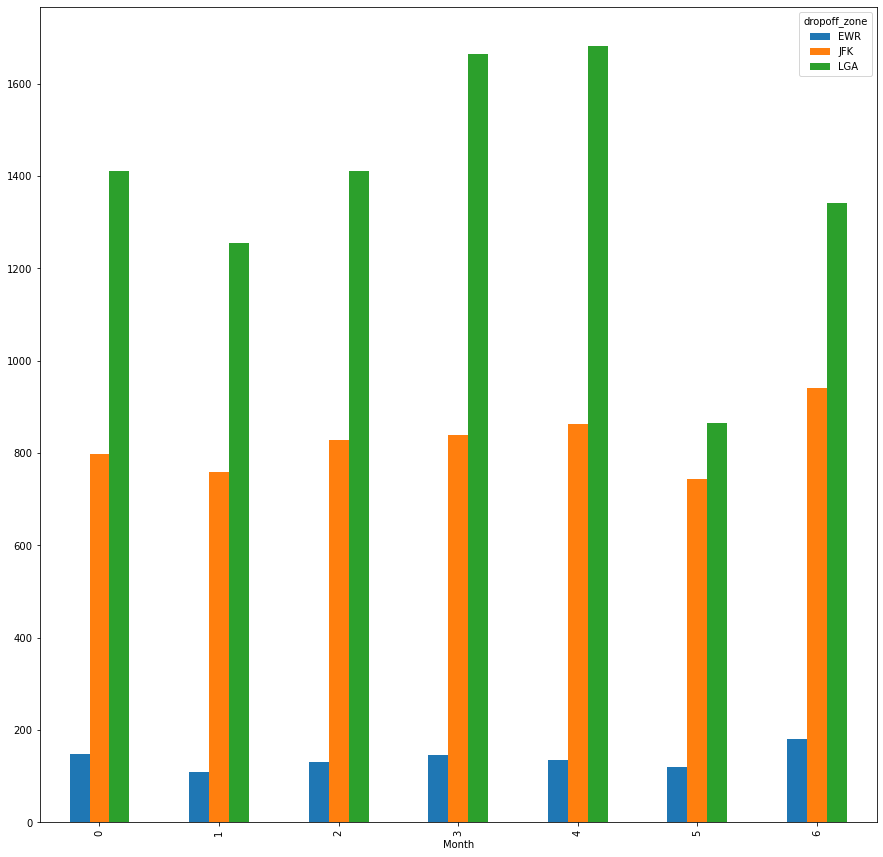

In [79]:
airports_dataframe = get_data_for_airports()
plot_visual_airports(airports_dataframe)

### Visualization:  A heatmap of all hired trips over a map of the area

A heatmap is generated from all of the hired trips over NYC, it is saved as an html file in which the visualization can be interacted with.

In [80]:
def plot_visual_heatmap(dataframe):

    map = KeplerGl(height=600, width=800)
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.pickup_longitude, dataframe.pickup_latitude))

    map.add_data(data=gdf, name="Hired Trips")
    map.save_to_html(file_name='hired_trips_heatmap.html')

In [81]:
def get_data_for_heatmap():
    query = """SELECT pickup_longitude, pickup_latitude FROM uber_trips
    UNION
    SELECT pickup_longitude, pickup_latitude FROM taxi_trips 
    WHERE pickup_longitude IS NOT NULL
    """
    df = pd.read_sql_query(query, engine)
    return df

In [82]:
heatmap_dataframe = get_data_for_heatmap()
plot_visual_heatmap(heatmap_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to hired_trips_heatmap.html!


### Visualization: The average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

Below, the months with a average distance, without considering major outliers in the distance traveled for months regardless of the month.

In [84]:
def plot_visual_distance_month(dataframe):
    avg_distance= dataframe.groupby('Month').mean()
    std_distance = dataframe.groupby('Month').std()
    count_distance = dataframe.groupby('Month').count()
    stats = dataframe.groupby(['Month'])['Distance'].agg(['mean', 'count', 'std'])
    ci95_hi = []
    ci95_lo = []
    error_amt = []
    
    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(m + 1.645*s/math.sqrt(c))
        ci95_lo.append(m - 1.645*s/math.sqrt(c))
        error_amt.append(1.645*s/math.sqrt(c))
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    stats["error_amt"] = error_amt
    figure, axes = plt.subplots(figsize=(20, 10))
    plt.bar(avg_distance.index, avg_distance["Distance"],alpha = 0.5)
    plt.errorbar(avg_distance.index, avg_distance["Distance"],yerr=stats["error_amt"])
    axes.set_title("Average Distance Traveled Each Month with 90 Percent Confidence Interval")
    
    plt.show()

In [85]:
def get_data_for_avg_trip_distance_per_month():
    query = """SELECT DATE(pickup_datetime), Distance FROM uber_trips
    UNION
    SELECT DATE(pickup_datetime), distance FROM taxi_trips 
    """
    df = pd.read_sql_query(query, engine)
    df= df[df.Distance<300]
    df["DATE(pickup_datetime)"] = df["DATE(pickup_datetime)"].astype('datetime64[ns]')
    df['Month'] = df["DATE(pickup_datetime)"].apply(lambda x:x.month)
    return df


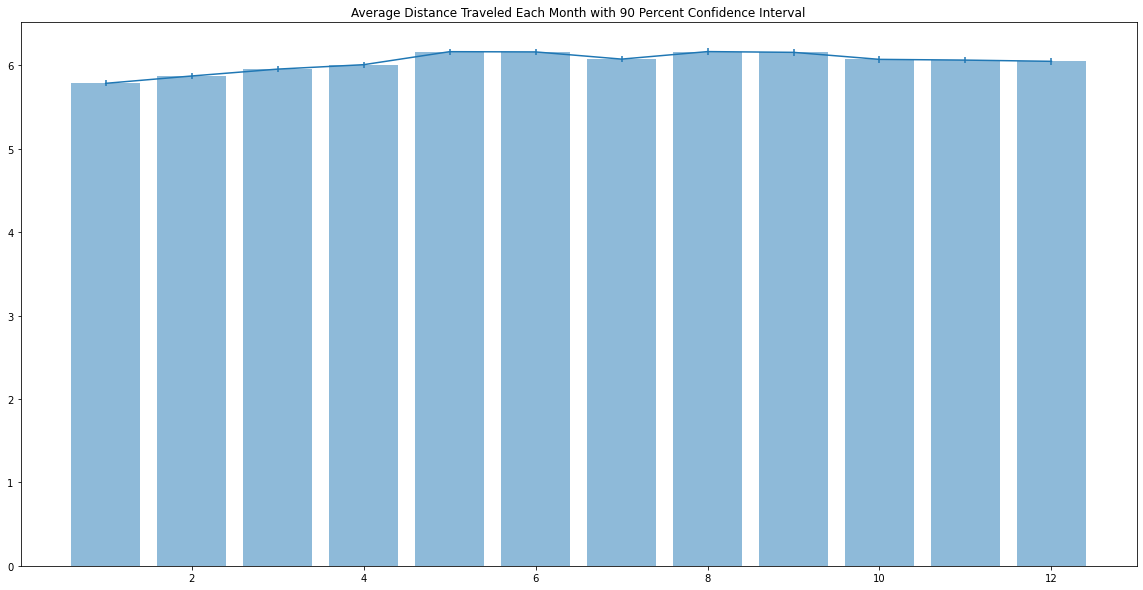

In [86]:
distance_month = get_data_for_avg_trip_distance_per_month()
plot_visual_distance_month(distance_month)

### Visualization:  A scatter plot that compares tip amount versus precipitation amount
Comparing Tip amount for taxis to the amount of precipitation at the time of the ride. In this visualization, one tip amount was exclueded as an outlier. This amount was over $800.

In [87]:
def plot_visual_tip_vs_preciptitation(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    dataframe =dataframe[dataframe.tip<800]
    plt.scatter(dataframe.precip,dataframe.tip)
    plt.xlim([0.01126, 0.01127])
    axes.set_title("Preciptiation During Each Hour Compared with Tip amount Of Those Rides")
    plt.ylabel("Tip Amount (Dollars)")
    plt.xlabel("Precipitation")
    plt.show()

In [88]:
def get_data_for_visual_tip_vs_preciptiation():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    query = """WITH taxi(hour, tip) AS (
    SELECT CAST(pickup_hour AS int) AS hour, tip_amount AS tip
    FROM taxi_trips),
    weather(hour, precip) AS (
    SELECT CAST(hours AS int) AS hour, AVG(HourlyPrecipitation) AS precip
    FROM hourly_weather)
    SELECT taxi.tip, weather.hour, weather.precip
    FROM weather
    LEFT JOIN taxi ON taxi.hour = weather.hour
    """
    data = pd.read_sql_query(query, engine)
    return data

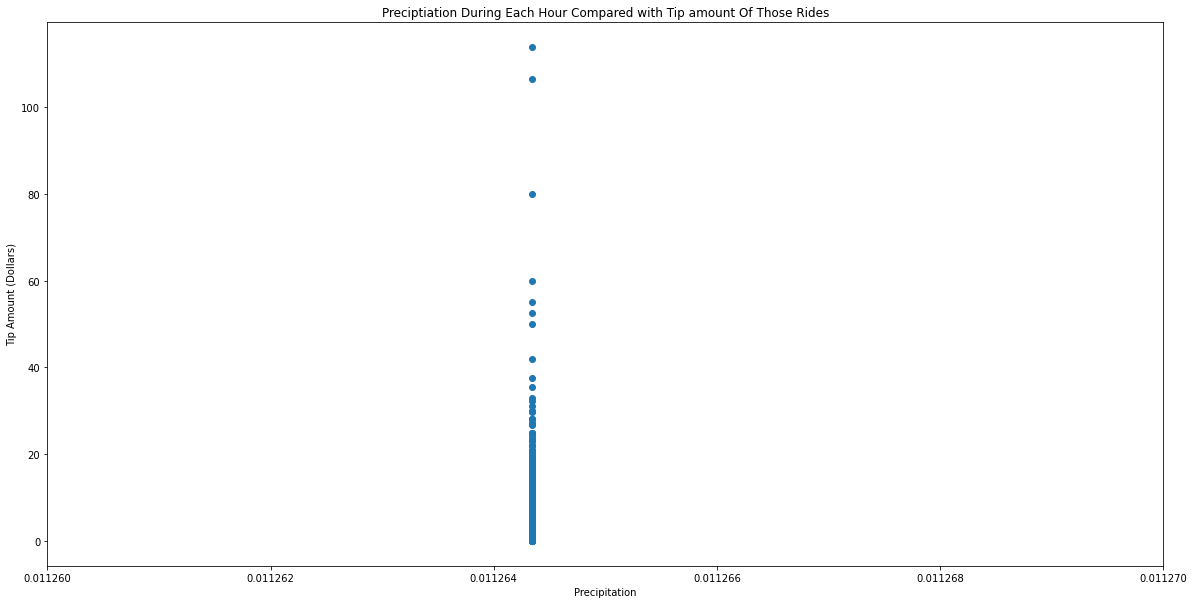

In [89]:
tip_vs_preciptitation_dataframe = get_data_for_visual_tip_vs_preciptiation()
plot_visual_tip_vs_preciptitation(tip_vs_preciptitation_dataframe)

### Visualization:  A scatter plot that compares tip amount versus distance
Below is a plot that compares the distance traveled to the tip amount recieved by taxi drivers in the NYC area.

In [90]:
def plot_visual_tip_distance(dataframe):

    figure, axes = plt.subplots(figsize=(20, 10))
    plt.scatter(dataframe.distance,dataframe.tip_amount)
    axes.set_title("Trip Distance Compared with Tip amount")
    plt.ylabel("Tip Amount (Dollars)")
    plt.xlabel("Distance (Miles)")
    plt.show()
    

In [91]:
def get_data_for_visual_distance_tip():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    query = "SELECT tip_amount, distance from taxi_trips"
    df = pd.read_sql_query(query, engine)
    df = df[df.distance<400]
    return df


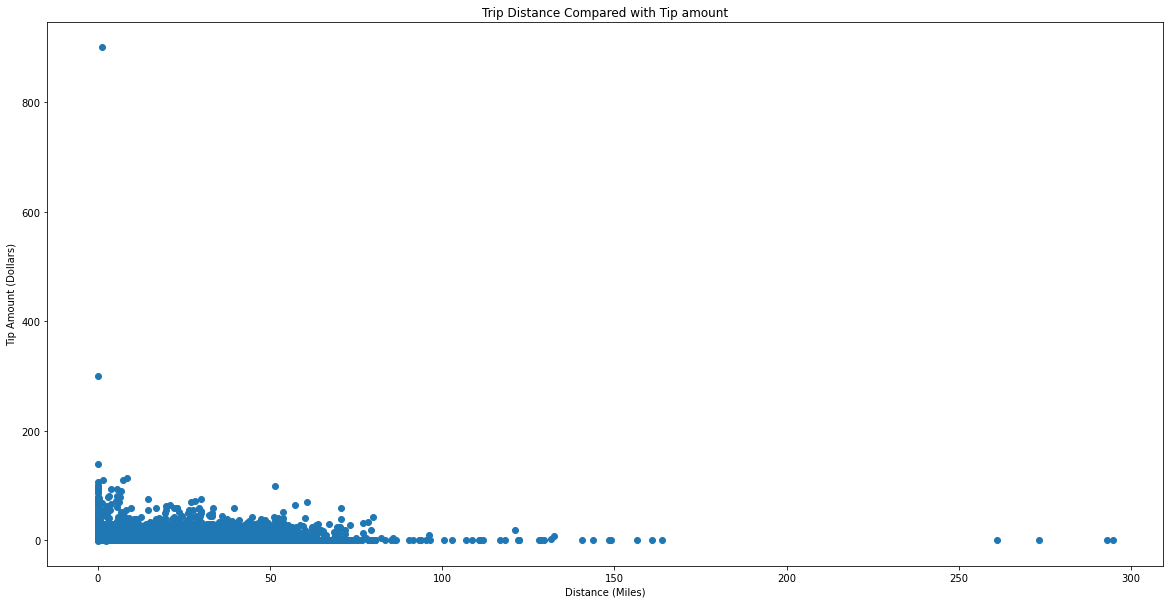

In [92]:
distance_tip_dataframe = get_data_for_visual_distance_tip()
plot_visual_tip_distance(distance_tip_dataframe)